In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
from PIL import Image
import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp109'

## read data

In [4]:
# waypointを補正したdataset
root_dir = Path('../../input/')

## subの用意

In [5]:
sub = pd.read_csv('../exp086/exp086_sub.csv')

## 後処理

## cost minimaization

In [6]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [7]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [8]:
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

# delta_x_coeff_site = pickle_load('../exp046/delta_magn_x_coeff.pkl')
# delta_y_coeff_site = pickle_load('../exp046/delta_magn_y_coeff.pkl')
delta_x_coeff_floor = pickle_load('../exp056/delta_magn_x_coeff_floor.pkl')
delta_y_coeff_floor = pickle_load('../exp056/delta_magn_y_coeff_floor.pkl')

In [9]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    example = read_data_file(root_dir/ f'indoor-location-navigation/test/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    # 相対位置に補正係数をかける
    site_id = path_df['site'].unique()[0]
    floor = int(path_df['floor'].unique()[0])

    # 辞書にsite-floorの組み合わせが存在していれば
    coeff_x = delta_x_coeff_floor['a'][f'{site_id}_{floor}'] 
    coeff_y = delta_y_coeff_floor['a'][f'{site_id}_{floor}'] 
    rel_positions[:, 1] = rel_positions[:, 1]*coeff_x  # ∆xの補正
    rel_positions[:, 2] = rel_positions[:, 2]*coeff_y  # ∆yの補正

    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def correct_path_train(args):
    #print(args)
    (site_id, path, floor, floor_str), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor_str}/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    # 相対位置に補正係数をかける
    # 辞書にsite-floorの組み合わせが存在していれば
    floor = int(floor)
    coeff_x = delta_x_coeff_floor['a'][f'{site_id}_{floor}'] 
    coeff_y = delta_y_coeff_floor['a'][f'{site_id}_{floor}'] 
    rel_positions[:, 1] = rel_positions[:, 1]*coeff_x  # ∆xの補正
    rel_positions[:, 2] = rel_positions[:, 2]*coeff_y  # ∆yの補正

    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state == 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)


In [10]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

## snap to grid

In [11]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [12]:
def visualize_onemap(train_waypoint, auto_waypoint, site, floor, dir_meta='../../input/indoor-location-navigation/metadata/', show=True, dpi=100):
    map_floor = {'B2': -2, 'B1': -1, 'F1': 0, 'F2': 1, 'F3': 2, 'F4': 3, 'F5': 4, 'F6': 5, 'F7': 6, 'F8': 7, 'F9': 8,
                 '2B': -2, '1B': -1, '1F': 0, '2F': 1, '3F': 2, '4F': 3, '5F': 4, '6F': 5, '7F': 6, '8F': 7, '9F': 8}
    path_json = f'{dir_meta}{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # show image
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    path_img = f'{dir_meta}{site}/{floor}/floor_image.png'
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
    ax.set_title(floor, fontsize=10)

    # train waypoint
    t_wp = train_waypoint.loc[(train_waypoint['site']==site)&(train_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    ax.scatter(t_wp['x'], t_wp['y'], marker='o', color='red', s=5, label='train')

    # auto waypoint
    a_wp = auto_waypoint.loc[(auto_waypoint['site']==site)&(auto_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    ax.scatter(a_wp['x'], a_wp['y'], marker='o', color='green', s=10, label='extra')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('auto_waypoint_sample.png')
    plt.show()

## add extra grid

In [13]:
# extra grid
LENGTH = 12
DISTANCE_LOWER = 3
DISTANCE_UPPER = 30
floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
            "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
            "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
            "7F":6, "8F": 7, "9F":8}

_train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')[['x', 'y', 'site', 'floor']] 
auto_waypoints = pd.read_csv(f'../../input/extra_grids/df_extra_grid_length_m_{LENGTH}.csv')  # ここにextra gridを追加
auto_waypoints = auto_waypoints[(DISTANCE_LOWER < auto_waypoints['distance'])&(auto_waypoints['distance'] < DISTANCE_UPPER)].reset_index(drop=True)
auto_waypoints['floor'] = auto_waypoints['floor'].replace(floor_map)
auto_waypoints

,x,y,distance,floor,site
0,213.160330,204.533430,20.550078,-1,5a0546857ecc773753327266
1,213.160330,192.681327,8.871904,-1,5a0546857ecc773753327266
2,225.002571,192.681327,14.434611,-1,5a0546857ecc773753327266
3,236.844811,192.681327,21.464054,-1,5a0546857ecc773753327266
4,59.211203,180.829224,4.950970,-1,5a0546857ecc773753327266
...,...,...,...,...,...
1218,201.467188,80.679885,19.442468,6,5dc8cea7659e181adb076a3f
1219,213.318199,80.679885,17.288496,6,5dc8cea7659e181adb076a3f
1220,225.169210,80.679885,6.273008,6,5dc8cea7659e181adb076a3f
1221,213.318199,68.815196,21.614756,6,5dc8cea7659e181adb076a3f


<AxesSubplot:>

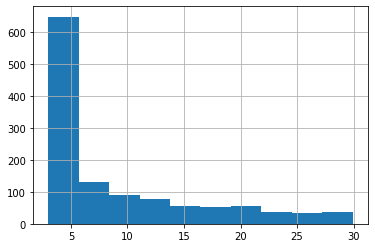

In [14]:
auto_waypoints['distance'].hist()

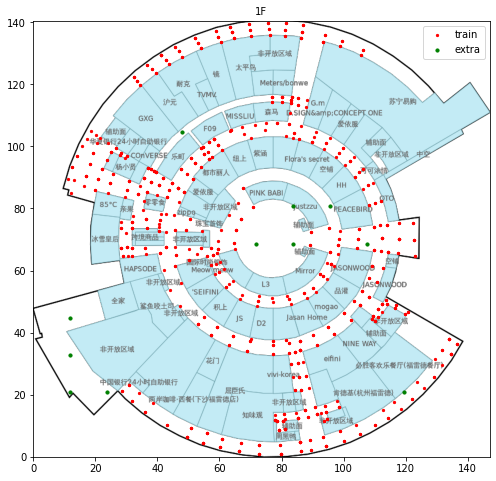

In [15]:
# sampleを可視化
ex_site = '5d2709d403f801723c32bd39'
ex_floor = '1F'
visualize_onemap(_train_waypoints, auto_waypoints, ex_site,ex_floor)

In [16]:
def post_processing_for_test(sub, n, auto_waypoints):

    sub_org = sub.copy()
    tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
    sub['site'] = tmp[0]
    sub['path'] = tmp[1]
    sub['timestamp'] = tmp[2].astype(float)

    ###############
    # cost min
    ###############
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    new_sub = pd.concat(dfs).sort_values('site_path_timestamp')

    ##############
    # snap to grid
    ##############
    train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')[['x', 'y', 'site', 'floor']]
    train_waypoints = pd.concat([train_waypoints, auto_waypoints]).reset_index(drop=True)
    new_sub = sub_process(new_sub, train_waypoints)
    new_sub = add_xy(new_sub)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in new_sub.groupby(['site','floor']):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                            (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['x_'] = d['matched_point'].apply(lambda x: x[0])
        d['y_'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    new_sub2 = pd.concat(ds)
    new_sub2 = new_sub2[['site_path_timestamp','floor','x_','y_']].sort_index()
    new_sub2 = new_sub2.rename(columns={'x_':'x', 'y_':'y'})
    return new_sub2

In [17]:
N = 6
sub = sub.reset_index()
for n in range(N):
    sub = post_processing_for_test(sub, n, auto_waypoints)

626it [00:47, 13.30it/s]
626it [00:47, 13.23it/s]
626it [00:48, 13.01it/s]
626it [00:47, 13.12it/s]
626it [00:47, 13.07it/s]
626it [00:47, 13.09it/s]


In [18]:
sub.to_csv(EXP_NAME + '_cost_snap_sub.csv', index=False)

## sub確認

In [19]:
sub = pd.read_csv(EXP_NAME + '_cost_snap_sub.csv')
sub

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.642690,104.500750
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.574510,101.132225
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,201.819690,104.936270
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.825880,109.711815


In [20]:
compare_sub = pd.read_csv("../exp086/exp086_cost_snap_sub.csv")
_x = compare_sub["x"]
_y = compare_sub["y"]
x = sub["x"]
y = sub["y"]

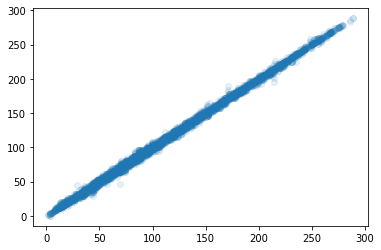

In [21]:
plt.scatter(x, _x, alpha=0.1)

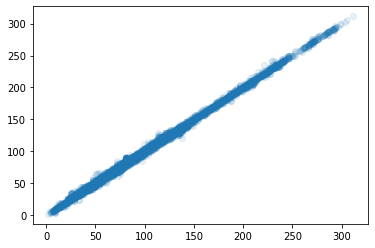

In [22]:
plt.scatter(y, _y, alpha=0.1)